# はじめに

このノートではLightGBMのランキング学習を理解するために、末尾に記載の資料を参考にしながら、ランキング学習の基礎からLightGBMのランキング学習アルゴリズムについて理解を深める。ただ、ランキング学習に関して、体系的に学べる書籍やサイトを見つけることができず、様々な資料を参考にしているため、部分的に私の解釈が誤っている可能性がある。本来は下記の書籍を読むのが望ましいと思われるが、高価なため読めていない。

- [Learning to Rank for Information Retrieval | Liu, Tie-Yan ](https://www.amazon.co.jp/Learning-Rank-Information-Retrieval-Tie-Yan/dp/3642142664)



## LightGBMとLTR

PythonのLightGBMライブラリには、`lightgbm.LGBMRanker`が用意されており、`objective='lambdarank'`と指定することでランキング学習が行える。

### Pairwise loss

詳細は前回のノートを参照するとして、クロスエントロピーの部分から始める。ここでは対数尤度からクロスエントロピーに変換しているのと、前回は正解ラベルを$\bar{P}_{ij}$としていたが、今回は$y_{ij}$と表している点は注意が必要。

$$
\begin{align*}
\mathcal{LL} &= y_{ij} log(P_{ij}) + (1-y_{ij})log(P_{ij}) \\
&= y_{ij}\log(\frac{1}{1 + e^{-\sigma (s_{i} - s_{j})}}) + (1 - y_{ij})\log(\frac{e^{-\sigma(s_{i} - s_{j})}}{1 + e^{-\sigma(s_{i} - s_{j})}}) \\
&= -y_{ij}\log(1 + e^{-\sigma (s_{i} - s_{j})}) + \log(e^{-\sigma (s_{i} - s_{j})}) - \log(1 + e^{-\sigma (s_{i} - s_{j})}) - y_{ij}\log(e^{-\sigma (s_{i} - s_{j})}) + y_{ij}\log(1 + e^{-\sigma (s_{i} - s_{j})}) \\
&= (1 - y_{ij})\log(e^{-\sigma (s_{i} - s_{j})}) - y_{ij}\log(1 + e^{-\sigma (s_{i} - s_{j})}) \\
\end{align*}
$$

対数尤度から考えているので、尤度にマイナスをつけ、クロスエントロピーを考える。つまりクロスエントロピーを最小化する。負の対数尤度はクロスエントロピーであり、`logloss`とも呼ばれる。

$$
logloss= (y_{ij}-1)\log(e^{-\sigma (s_{i} - s_{j})}) + y_{ij}\log(1 + e^{-\sigma (s_{i} - s_{j})})
$$

$y_{ij}$があればよいので、$y_{ij}=1$を考えると、

$$
\begin{align*}
logloss &= (1-1)\log(e^{-\sigma (s_{i} - s_{j})}) + 1\log(1 + e^{-\sigma (s_{i} - s_{j})}) \\
&= \log(1 + e^{-\sigma (s_{i} - s_{j})})
\end{align*}
$$

であり、$y_{ij}=0$を考えると、

$$
\begin{align*}
logloss &= (1-0)\log(e^{-\sigma (s_{i} - s_{j})}) + 0\log(1 + e^{-\sigma (s_{i} - s_{j})}) \\
&= \log(1 + e^{-\sigma (s_{i} - s_{j})})
\end{align*}
$$

となり、シンプルに考えることができる。


### LambdaMart

LightGBMで利用できるLambdaMartは、LambdaRankがベースになっている。LambdaRankは、RankNetだけでは解消できない、ランキングの質を改良するためにnDCGの変化率を利用しているものである。

$$
\lambda_{LambdaRank} = \lambda_{RankNet} |\Delta nDCG|
$$

LightGBMの勾配ブースティングは、テイラー展開によって近似を行い、最小化する損失関数の1次微分(勾配$g$)と2次微分(ヘシアン$h$)を利用する。このあたりの理解を深める。まずは1次微分(勾配$g$)については次の通り。最後を$\lambda_{ij}$とおいているのは、この後にlightGBMのコードを覗くので、そのときの変数名と合わせている。

$$
\begin{align*}
\frac{\partial logloss}{\partial s_i} &= -\dfrac{{\sigma}}{\mathrm{e}^{{\sigma}\cdot\left(x-b\right)}+1}\\
&= \lambda_{ij}
\end{align*}
$$

2次微分(ヘシアン$h$)については次の通り。

$$
\begin{align*}
\frac{\partial^2 logloss}{\partial^2 s_i} &= \frac{\sigma^{2}e^{-\sigma(s_{j} - s_{i})}|\Delta NDCG_{ij}|}{(1 + e^{-\sigma(s_{j} - s_{i})})^{2}} \\
&= \sigma^{2}|\Delta NDCG_{ij}| \frac{e^{\sigma(s_{i} - s_{j})}}{(1 + e^{\sigma(s_{i} - s_{j})})^{2}} \\
&= \frac{-\sigma}{1 + e^{-\sigma(s_{j} - s_{i})}}|\Delta NDCG_{ij}| \cdot \frac{-\sigma e^{-\sigma(s_{j} - s_{i})}}{1 + e^{-\sigma(s_{j} - s_{i})}} \\
&= \lambda_{ij}\frac{-\sigma e^{-\sigma(s_{j} - s_{i})}}{1 + e^{-\sigma(s_{j} - s_{i})}}
\end{align*}
$$

下記のブログを書かれていた方が、LightGBMのlambdarankの実装をC++で書かれたソースコードを見ながら解剖していたので、その内容を参考にしながら、内部動作を理解する。

- [The inner workings of the lambdarank objective in LightGBM](https://ffineis.github.io/blog/2021/05/01/lambdarank-lightgbm.html)

lambdarankでは、`GetGradients`で、データ内のクエリを分割し、各クエリ内の各アイテムのペアワイズ損失と勾配/ヘシアンを繰り返し計算している。計算は `GetGradientsForOneQuery`を呼び出して実行している。

From: https://github.com/microsoft/LightGBM/blob/a70e832782445e5f49f2a5400896f2dc21475037/src/objective/rank_objective.hpp#L59C1-L72C68

```cpp
-------------------------------------------------------------------------------------------------------------------------
void GetGradients(const double* score, score_t* gradients,
                    score_t* hessians) const override {
    ...
    for (data_size_t i = 0; i < num_queries_; ++i) {
      const data_size_t start = query_boundaries_[i];
      const data_size_t cnt = query_boundaries_[i + 1] - query_boundaries_[i];
      ...

      GetGradientsForOneQuery(i, cnt, label_ + start, num_position_ids_ > 0 ? score_adjusted.data() : score + start,
                              gradients + start, hessians + start);
        ...
    }
}
-------------------------------------------------------------------------------------------------------------------------
```


そして、勾配やヘシアンを計算しているのは下記の関数である。大まかな流れとしては、次の通り。

1. `GetGradientsForOneQuery`関数は、1つのクエリに対して勾配とヘシアンを計算するために、引数として、クエリID、データポイント数、ラベル、スコア、勾配、ヘシアンを取る。
2. 最初に、各データポイントの勾配とヘシアンをゼロで初期化
3. 次に、スコアが降順にソートされたインデックスを取得し、スコアが高いデータポイントから低いデータポイントへのインデックスが得る。
4. 最高スコアと最低スコアを特定し、各データポイントのラベルを考慮して、nDCGの計算に使用するディスカウント値を取得。
5. その後、各データポイントのペアに対して、nDCGの変化を基にした勾配とヘシアンを計算。ペアのスコアの差が大きいほど、nDCGの変化が大きくなる。
6. 最後に、必要に応じて勾配とヘシアンを正規化。これは、モデルの学習速度や安定性を向上させるために行われる。

From | https://github.com/microsoft/LightGBM/blob/a70e832782445e5f49f2a5400896f2dc21475037/src/objective/rank_objective.hpp#L174C3-L260C4


```cpp
-------------------------------------------------------------------------------------------------------------------------
inline void GetGradientsForOneQuery(data_size_t query_id, data_size_t cnt,
                                      const label_t* label, const double* score,
                                      score_t* lambdas,
                                      score_t* hessians) const override {
    // 現在のクエリにおける最大のDCG（Discounted Cumulative Gain）の逆数を取得する
    const double inverse_max_dcg = inverse_max_dcgs_[query_id];

    // 各データポイントの勾配（lambda）とヘシアンをゼロで初期化する
    for (data_size_t i = 0; i < cnt; ++i) {
      lambdas[i] = 0.0f;
      hessians[i] = 0.0f;
    }

    // スコアが降順にソートされたインデックスを取得する
    std::vector<data_size_t> sorted_idx(cnt);
    for (data_size_t i = 0; i < cnt; ++i) {
      sorted_idx[i] = i;
    }
    std::stable_sort(
        sorted_idx.begin(), sorted_idx.end(),
        [score](data_size_t a, data_size_t b) { return score[a] > score[b]; });

    // 最高スコアと最低スコアを特定する
    const double best_score = score[sorted_idx[0]];
    data_size_t worst_idx = cnt - 1;
    if (worst_idx > 0 && score[sorted_idx[worst_idx]] == kMinScore) {
      worst_idx -= 1;
    }
    const double worst_score = score[sorted_idx[worst_idx]];
    double sum_lambdas = 0.0;

    // 切り捨てレベル以上の少なくとも1つのドキュメントを含むペアの勾配とヘシアンを計算する
    for (data_size_t i = 0; i < cnt - 1 && i < truncation_level_; ++i) {
      if (score[sorted_idx[i]] == kMinScore) { continue; }
      for (data_size_t j = i + 1; j < cnt; ++j) {
        if (score[sorted_idx[j]] == kMinScore) { continue; }
        // 同じラベルを持つペアは無視する
        if (label[sorted_idx[i]] == label[sorted_idx[j]]) { continue; }
        data_size_t high_rank, low_rank;
        if (label[sorted_idx[i]] > label[sorted_idx[j]]) {
          high_rank = i;
          low_rank = j;
        } else {
          high_rank = j;
          low_rank = i;
        }
        const data_size_t high = sorted_idx[high_rank];
        const int high_label = static_cast<int>(label[high]);
        const double high_score = score[high];
        const double high_label_gain = label_gain_[high_label];
        const double high_discount = DCGCalculator::GetDiscount(high_rank);
        const data_size_t low = sorted_idx[low_rank];
        const int low_label = static_cast<int>(label[low]);
        const double low_score = score[low];
        const double low_label_gain = label_gain_[low_label];
        const double low_discount = DCGCalculator::GetDiscount(low_rank);

        const double delta_score = high_score - low_score;

        // DCGギャップを計算する
        const double dcg_gap = high_label_gain - low_label_gain;
        // このペアの割引率を取得する
        const double paired_discount = fabs(high_discount - low_discount);
        // ΔNDCGを計算する
        double delta_pair_NDCG = dcg_gap * paired_discount * inverse_max_dcg;
        // スコアの距離によってdelta_pair_NDCGを規格化する
        if (norm_ && best_score != worst_score) {
          delta_pair_NDCG /= (0.01f + fabs(delta_score));
        }
        // このペアのλ（勾配）を計算する
        double p_lambda = GetSigmoid(delta_score);
        double p_hessian = p_lambda * (1.0f - p_lambda);
        // 更新する
        p_lambda *= -sigmoid_ * delta_pair_NDCG;
        p_hessian *= sigmoid_ * sigmoid_ * delta_pair_NDCG;
        lambdas[low] -= static_cast<score_t>(p_lambda);
        hessians[low] += static_cast<score_t>(p_hessian);
        lambdas[high] += static_cast<score_t>(p_lambda);
        hessians[high] += static_cast<score_t>(p_hessian);
        // λは負なので、マイナスを使って蓄積する
        sum_lambdas -= 2 * p_lambda;
      }
    }
    // 必要に応じて勾配とヘシアンを正規化する
    if (norm_ && sum_lambdas > 0) {
      double norm_factor = std::log2(1 + sum_lambdas) / sum_lambdas;
      for (data_size_t i = 0; i < cnt; ++i) {
        lambdas[i] = static_cast<score_t>(lambdas[i] * norm_factor);
        hessians[i] = static_cast<score_t>(hessians[i] * norm_factor);
      }
    }
  }
-------------------------------------------------------------------------------------------------------------------------
```


下記の部分で勾配とヘシアンを計算している。`p_hessian = p_lambda * (1 - p_lambda)`で計算するとなぜヘシアンとなるのか理解に苦しむが、ありがたいことに、この点はブログを書いた方が解決していた。

```cpp
-------------------------------------------------------------------------------------------------------------------------
// DCGギャップを計算する
const double dcg_gap = high_label_gain - low_label_gain;
// このペアの割引率を取得する
const double paired_discount = fabs(high_discount - low_discount);
// ΔNDCGを計算する
double delta_pair_NDCG = dcg_gap * paired_discount * inverse_max_dcg;
// このペアのλ（勾配）を計算する
double p_lambda = GetSigmoid(delta_score);              // 1 / (1 + e^(sigma * (s_i - s_j)))
double p_hessian = p_lambda * (1.0f - p_lambda);        // Begin hessian calculation.
// 更新
p_lambda *= -sigmoid_ * delta_pair_NDCG;                // Finish lambdarank gradient: -sigma * |NDCG| / (1 + e^(sigma * (s_i - s_j)))
p_hessian *= sigmoid_ * sigmoid_ * delta_pair_NDCG;     // Finish hessian calculation. See derivation below.
-------------------------------------------------------------------------------------------------------------------------
```

コードと数式を結びつけると、下記の通りとなる。

$$
\begin{align*}
\text{p\_lambda} &= \frac{1}{1 + e^{\sigma(s_{i} - s_{j})}} \\
1 - \text{p\_lambda} &= \frac{e^{\sigma(s_{i} - s_{j})}}{1 + e^{\sigma(s_{i} - s_{j})}} \\
\text{p\_lambda}(1 - \text{p\_lambda}) &= \frac{e^{\sigma(s_{i} - s_{j})}}{(1 + e^{\sigma(s_{i} - s_{j})})^{2}} \\
\Rightarrow \frac{\partial^{2}\text{logloss}}{\partial s_{i}^{2}} &= \sigma^{2}|\Delta NDCG_{ij}|\text{p\_lambda}(1 - \text{p\_lambda}) \\
&= \sigma^{2}|\Delta NDCG_{ij}|\frac{e^{\sigma(s_{i} - s_{j})}}{(1 + e^{\sigma(s_{i} - s_{j})})^{2}} \\
\end{align*}
$$

ヘシアンを計算した２行目と一致していることがわかる。

$$
\begin{align*}
\frac{\partial^2 logloss}{\partial^2 s_i} &= \frac{\sigma^{2}e^{-\sigma(s_{j} - s_{i})}|\Delta NDCG_{ij}|}{(1 + e^{-\sigma(s_{j} - s_{i})})^{2}} \\
&= \sigma^{2}|\Delta NDCG_{ij}| \frac{e^{\sigma(s_{i} - s_{j})}}{(1 + e^{\sigma(s_{i} - s_{j})})^{2}} \\
\end{align*}
$$

非常にありがたいブログのおかげで、理解を深めることができた。LambdaMartでは、これらの勾配を利用しながら、ブースティングごとにペアワイズ損失を最小化しながら学習を進めていく。

## LambdaMartの実装

LightGBMライブラリを利用して、LambdaMartを動かしてみる。動かすことが目的なので、細かい部分は気にしない。まずは最低限必要なライブラリをインポートしておく。

In [10]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import ndcg_score


ダミーデータの作り方は、末尾に記載している。ここではクエリは1000個、各クエリにドキュメントの特徴量がランダムに2個以上紐づいている。関連性スコアは`relevance`カラムに保存されている。

In [11]:
df = pd.read_csv('dummy_data.csv')
df.head(20)

,qid,product_id,f1,f2,f3,f4,f5,f6,f7,f8,relevance
0,0,9091959836,1,4,0,1,0,1,0,1,3.010598
1,0,7022556754,2,6,1,1,0,1,0,0,1.232206
2,1,7260796519,2,6,1,1,0,0,0,0,0.823347
3,1,8058168526,2,0,1,1,0,0,1,0,1.736981
4,2,6986962439,1,2,0,2,0,0,0,0,2.903618
5,2,7171414759,0,6,1,1,0,1,1,0,9.339263
6,3,6146147319,2,1,0,0,1,1,0,1,2.444349
7,3,1168306588,0,2,0,0,1,0,0,0,0.425337
8,4,6566536540,2,0,0,2,1,1,1,0,3.395474
9,4,7587224658,2,2,1,2,1,1,0,1,0.400511


クエリ`qid`に基づいてデータを分割する。1000個のクエリがあるので、訓練用に60%、検証用、テスト用に20%の分割を実行する。

In [12]:
train = df[df['qid'] < 600]
valid = df[(df['qid'] >= 600) & (df['qid'] < 800)]  # 条件を括弧で囲む
test = df[df['qid'] >= 800]

print(f"No of unique queries in train : {train['qid'].nunique()}")
print(f"No of unique queries in valid : {valid['qid'].nunique()}")
print(f"No of unique queries in test : {test['qid'].nunique()}")


No of unique queries in train : 600
No of unique queries in valid : 200
No of unique queries in test : 200


LightGBMのLambdaMARTモデルの学習前に、データを特徴量と関連性スコアに分割し、データセット作成する。特徴的なのは、各クエリが何個のドキュメントと紐づいているのかを表す`qids_*`も必要になる。

In [13]:
qids_train = train.groupby("qid")["qid"].count().to_numpy()
X_train = train.drop(["qid", "relevance", "product_id"], axis = 1)
y_train = train['relevance'].astype(int)

qids_valid = valid.groupby("qid")["qid"].count().to_numpy()
X_valid = valid.drop(["qid", "relevance", "product_id"], axis = 1)
y_valid = valid['relevance'].astype(int)

qids_test = test.groupby("qid")["qid"].count().to_numpy()
X_test = test.drop(["qid", "relevance", "product_id"], axis = 1)
y_test = test['relevance'].astype(int)

train = lgb.Dataset(X_train, y_train, group=qids_train)
valid = lgb.Dataset(X_valid, y_valid, reference=train, group=qids_valid)


あとはパラメタをセットして、学習する。

In [14]:
params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'lambdarank_truncation_level': 10,
    'ndcg_eval_at': [3, 5, 10],
    'n_estimators': 1000,
    'boosting_type': 'gbdt',
    'random_state': 1,
    'verbose': -1
}
# この数字を1にすると学習時のスコア推移がコマンドライン表示される
# verbose_eval = 0
model = lgb.train(
    params, 
    train_set=train, 
    valid_sets=[valid], 
    valid_names=['valid'],
    num_boost_round=10000,  
    # early_stopping用コールバック関数
    callbacks=[
      lgb.early_stopping(stopping_rounds=100, verbose=True), 
      lgb.log_evaluation(5),
      #lgb.log_evaluation(verbose_eval)
      ]
)


Training until validation scores don't improve for 100 rounds
[5]	valid's ndcg@3: 0.861281	valid's ndcg@5: 0.867834	valid's ndcg@10: 0.867834
[10]	valid's ndcg@3: 0.859273	valid's ndcg@5: 0.865043	valid's ndcg@10: 0.865043
[15]	valid's ndcg@3: 0.848415	valid's ndcg@5: 0.855635	valid's ndcg@10: 0.855635
[20]	valid's ndcg@3: 0.841871	valid's ndcg@5: 0.846972	valid's ndcg@10: 0.846972
[25]	valid's ndcg@3: 0.853697	valid's ndcg@5: 0.859596	valid's ndcg@10: 0.859596
[30]	valid's ndcg@3: 0.849672	valid's ndcg@5: 0.855571	valid's ndcg@10: 0.855571
[35]	valid's ndcg@3: 0.856275	valid's ndcg@5: 0.862175	valid's ndcg@10: 0.862175
[40]	valid's ndcg@3: 0.859896	valid's ndcg@5: 0.864967	valid's ndcg@10: 0.864967
[45]	valid's ndcg@3: 0.860689	valid's ndcg@5: 0.865759	valid's ndcg@10: 0.865759
[50]	valid's ndcg@3: 0.861372	valid's ndcg@5: 0.866442	valid's ndcg@10: 0.866442
[55]	valid's ndcg@3: 0.860643	valid's ndcg@5: 0.865713	valid's ndcg@10: 0.865713
[60]	valid's ndcg@3: 0.860458	valid's ndcg@5: 0.

/Users/aki/miniforge3/envs/boat/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[90]	valid's ndcg@3: 0.874351	valid's ndcg@5: 0.878623	valid's ndcg@10: 0.878623
[95]	valid's ndcg@3: 0.872453	valid's ndcg@5: 0.876495	valid's ndcg@10: 0.876495
[100]	valid's ndcg@3: 0.869213	valid's ndcg@5: 0.873256	valid's ndcg@10: 0.873256
[105]	valid's ndcg@3: 0.865581	valid's ndcg@5: 0.869624	valid's ndcg@10: 0.869624
[110]	valid's ndcg@3: 0.863484	valid's ndcg@5: 0.867527	valid's ndcg@10: 0.867527
[115]	valid's ndcg@3: 0.865805	valid's ndcg@5: 0.869847	valid's ndcg@10: 0.869847
[120]	valid's ndcg@3: 0.863817	valid's ndcg@5: 0.86786	valid's ndcg@10: 0.86786
[125]	valid's ndcg@3: 0.863412	valid's ndcg@5: 0.867455	valid's ndcg@10: 0.867455
[130]	valid's ndcg@3: 0.868755	valid's ndcg@5: 0.872798	valid's ndcg@10: 0.872798
[135]	valid's ndcg@3: 0.866827	valid's ndcg@5: 0.87087	valid's ndcg@10: 0.87087
[140]	valid's ndcg@3: 0.862824	valid's ndcg@5: 0.866867	valid's ndcg@10: 0.866867
[145]	valid's ndcg@3: 0.863839	valid's ndcg@5: 0.867882	valid's ndcg@10: 0.867882
[150]	valid's ndcg@3: 

変数重要度も確認できる。

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

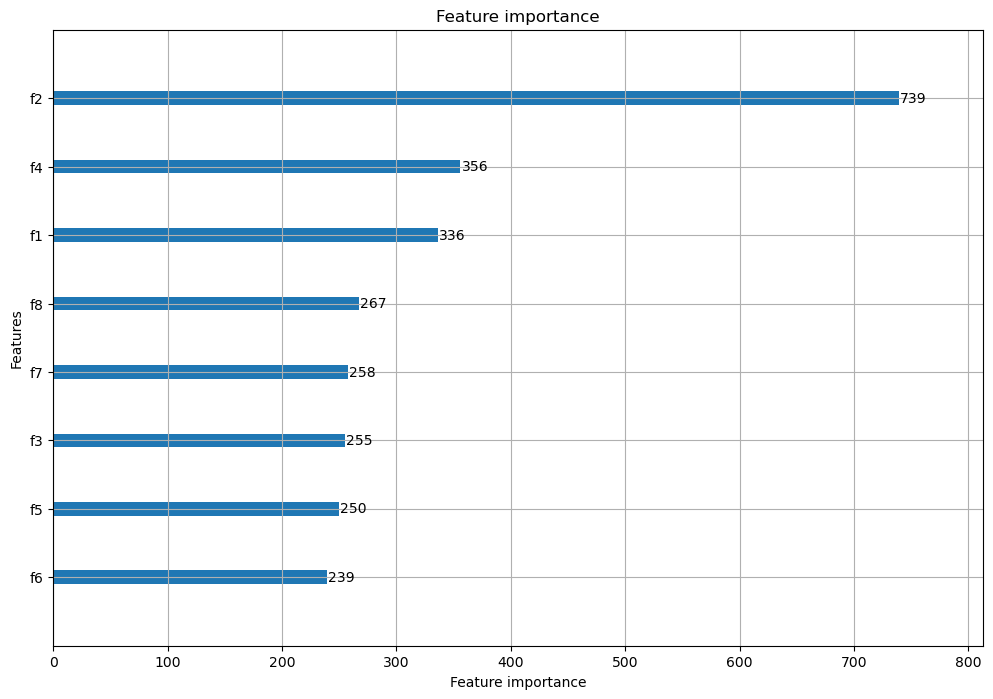

In [15]:
lgb.plot_importance(model, figsize = (12,8))

クエリごとに NDCG@10 を計算し，その平均値を評価値とする。`pred`はランキングモデルのスコアを表しており、スコアが大きいほど高い順位にあるアイテムだということを表す。



In [16]:
pred = model.predict(X_test, num_iteration=model.best_iteration)
# 予測値にクエリ ID とランキングと正解を付与する
pred_df = pd.DataFrame({
    "qid": np.repeat(np.arange(qids_test.shape[0]), qids_test.astype(int)),
    "pred": pred,
    "true": y_test,
})
pred_df.head(15)

,qid,pred,true
1677,0,0.551974,1
1678,0,0.492736,1
1679,1,0.460679,7
1680,1,0.748025,3
1681,2,1.115049,3
1682,2,0.864532,2
1683,3,0.492307,3
1684,3,0.979852,3
1685,4,0.567264,6
1686,4,0.128598,1


In [17]:
pred_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 419 entries, 1677 to 2095
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   qid     419 non-null    int64  
 1   pred    419 non-null    float64
 2   true    419 non-null    int64  
dtypes: float64(1), int64(2)
memory usage: 13.1 KB


In [18]:
# qidごとに NDCG@10を計算して平均値を算出
pred_df.groupby('qid').apply(lambda d: ndcg_score([d['true']], [d['pred']], k=10)).mean()

0.8675281262853872

## 参考資料

- [The inner workings of the lambdarank objective in LightGBM](https://ffineis.github.io/blog/2021/05/01/lambdarank-lightgbm.html)
- [Anime Recommendation LTR Dataset](https://www.kaggle.com/datasets/ransakaravihara/anime-recommendation-ltr-dataset)
- [lightgbm.LGBMRanker — LightGBM 4.0.0 ドキュメント](https://lightgbm.readthedocs.io/en/stable/pythonapi/lightgbm.LGBMRanker.html)
- [Learn to Implement a Learning-to-Rank Model for Product Recommendations: A Step-by-Step Guide | Towards Data Science](https://towardsdatascience.com/how-to-implement-learning-to-rank-model-using-python-569cd9c49b08)
- [LightGBM でかんたん Learning to Rank - 霧でも食ってろ](https://knuu.github.io/ltr_by_lightgbm.html)
- [A Practical Guide to LambdaMART in LightGbm | by Akash Dubey | DataDrivenInvestor](https://medium.datadriveninvestor.com/a-practical-guide-to-lambdamart-in-lightgbm-f16a57864f6)


## 備考

サンプルダミーデータを作るためのコード

```python
import pandas as pd
import numpy as np

# ランダムなデータの生成
num_samples = 1000
np.random.seed(1)
qids = np.random.randint(0, 1000, size=num_samples) 
product_ids = np.random.randint(1e9, 1e10, size=num_samples)
f1 = np.random.randint(0, 3, size=num_samples)
f2 = np.random.randint(0, 7, size=num_samples)
f3 = np.random.randint(0, 2, size=num_samples)
f4 = np.random.randint(0, 3, size=num_samples)
f5 = np.random.randint(0, 2, size=num_samples)
f6 = np.random.randint(0, 2, size=num_samples)
f7 = np.random.randint(0, 2, size=num_samples)
f8 = np.random.randint(0, 2, size=num_samples)
relevance = np.random.uniform(0, 4, size=num_samples)

# ダミーデータの追加
dummy_data = pd.DataFrame({
    'qid': qids,
    'product_id': product_ids,
    'f1': f1,
    'f2': f2,
    'f3': f3,
    'f4': f4,
    'f5': f5,
    'f6': f6,
    'f7': f7,
    'f8': f8,
    'relevance': relevance
})

# qidの出現を確認し、必要な値が欠けている場合は補完する
missing_qids = set(range(1000)) - set(dummy_data['qid'].unique())
missing_rows = []
for qid in missing_qids:
    missing_rows.append({
        'qid': qid,
        'product_id': np.random.randint(1e9, 1e10),
        'f1': np.random.randint(0, 3),
        'f2': np.random.randint(0, 7),
        'f3': np.random.randint(0, 2),
        'f4': np.random.randint(0, 3),
        'f5': np.random.randint(0, 2),
        'f6': np.random.randint(0, 2),
        'f7': np.random.randint(0, 2),
        'f8': np.random.randint(0, 2),
        'relevance': np.random.uniform(0, 10)
    })

dummy_data = pd.concat([dummy_data, pd.DataFrame(missing_rows)], ignore_index=True)

# 各qidの出現回数を計算
qid_counts = dummy_data['qid'].value_counts()

# 出現回数が1回のqidを取得
single_qids = qid_counts[qid_counts == 1].index.tolist()

# 出現回数が1回のqidに対して追加のレコードを生成
additional_rows = []
for qid in single_qids:
    additional_rows.append({
        'qid': qid,
        'product_id': np.random.randint(1e9, 1e10),
        'f1': np.random.randint(0, 3),
        'f2': np.random.randint(0, 7),
        'f3': np.random.randint(0, 2),
        'f4': np.random.randint(0, 3),
        'f5': np.random.randint(0, 2),
        'f6': np.random.randint(0, 2),
        'f7': np.random.randint(0, 2),
        'f8': np.random.randint(0, 2),
        'relevance': np.random.uniform(0, 4)
    })

# 追加のレコードを元のデータフレームに追加
dummy_data = pd.concat([dummy_data, pd.DataFrame(additional_rows)], ignore_index=True)

# 結果の表示
dummy_data = dummy_data.sort_values('qid')
dummy_data.to_csv('./dummy_data.csv', index=False)
```